VCS Dataset Shape: (382, 13)
CDM Dataset Shape: (1686, 7)

VCS Columns: ['ID', 'Name', 'Proponent', 'Project Type', 'AFOLU Activities', 'Methodology', 'Status', 'Country/Area', 'Estimated Annual Emission Reductions', 'Region', 'Project Registration Date', 'Crediting Period Start Date', 'Crediting Period End Date']

CDM Columns: ['Registered', 'Project title', 'Host parties', 'Other Parties', 'Methodology', 'Reductions', 'Ref']

VCS Sample:


,ID,Name,Proponent,Project Type,AFOLU Activities,Methodology,Status,Country/Area,Estimated Annual Emission Reductions,Region,Project Registration Date,Crediting Period Start Date,Crediting Period End Date
0,5053,EASY BREATHE INDIA SMART COOKSTOVE PROGRAM,EVI Green Markets Pte. Ltd.,Energy demand,NaN,VMR0006,Registered,India,"1,720",Asia,2025-04-23,2023-05-29,2030-05-28
1,4984,CLEAN BIO-ENERGY INITIATIVE IN MADHYA PRADESH...,Ecological Restoration Organization,Energy industries (renewable/non-renewable sou...,NaN,AMS-I.E.,Registered,India,"28,895",NaN,2025-05-01,2022-09-09,2032-09-08
2,4982,RBML (Reliance BP Mobility Limited) EV Chargin...,Reliance BP Mobility Limited,Energy industries (renewable/non-renewable sou...,NaN,VM0038,Registered,India,"1,068,196",Asia,2025-04-16,2022-03-24,2032-03-23
3,4775,Grouped Solar Power Project by Indospace Devel...,Multiple Proponents,Energy industries (renewable/non-renewable sou...,NaN,AMS-I.F.,Registered,India,"8,233",Asia,2024-11-22,2022-04-27,2029-04-26
4,4731,Biogas based Poultry Waste Management Project ...,Sunmax Hatcheries Private Limited,Energy industries (renewable/non-renewable sou...,NaN,AMS-I.F.; AMS-III.D.,Registered,India,"26,608",Asia,2024-09-15,2024-01-28,2031-01-27



CDM Sample:


,Registered,Project title,Host parties,Other Parties,Methodology,Reductions,Ref
0,08/03/2005,Project for GHG emission reduction by thermal ...,India,Switzerland/ Japan/ Netherlands/ Italy/ United...,AM0001 ver. 2,3000000,1
1,23/05/2005,Biomass in Rajasthan - Electricity generation ...,India,Netherlands/ Germany,AMS-I.D. ver. 5,31374,58
2,18/07/2005,5 MW Dehar Grid-connected SHP in Himachal Prad...,India,Germany,AMS-I.D. ver. 5,16374,35
3,06/08/2005,Clarion 12MW (Gross) Renewable Sources Biomass...,India,Switzerland/ United Kingdom of Great Britain a...,AMS-I.D. ver. 5,26300,75
4,23/09/2005,SRS Bagasse Cogeneration Project,India,United Kingdom of Great Britain and Northern I...,AMS-I.D. ver. 5,22000,80


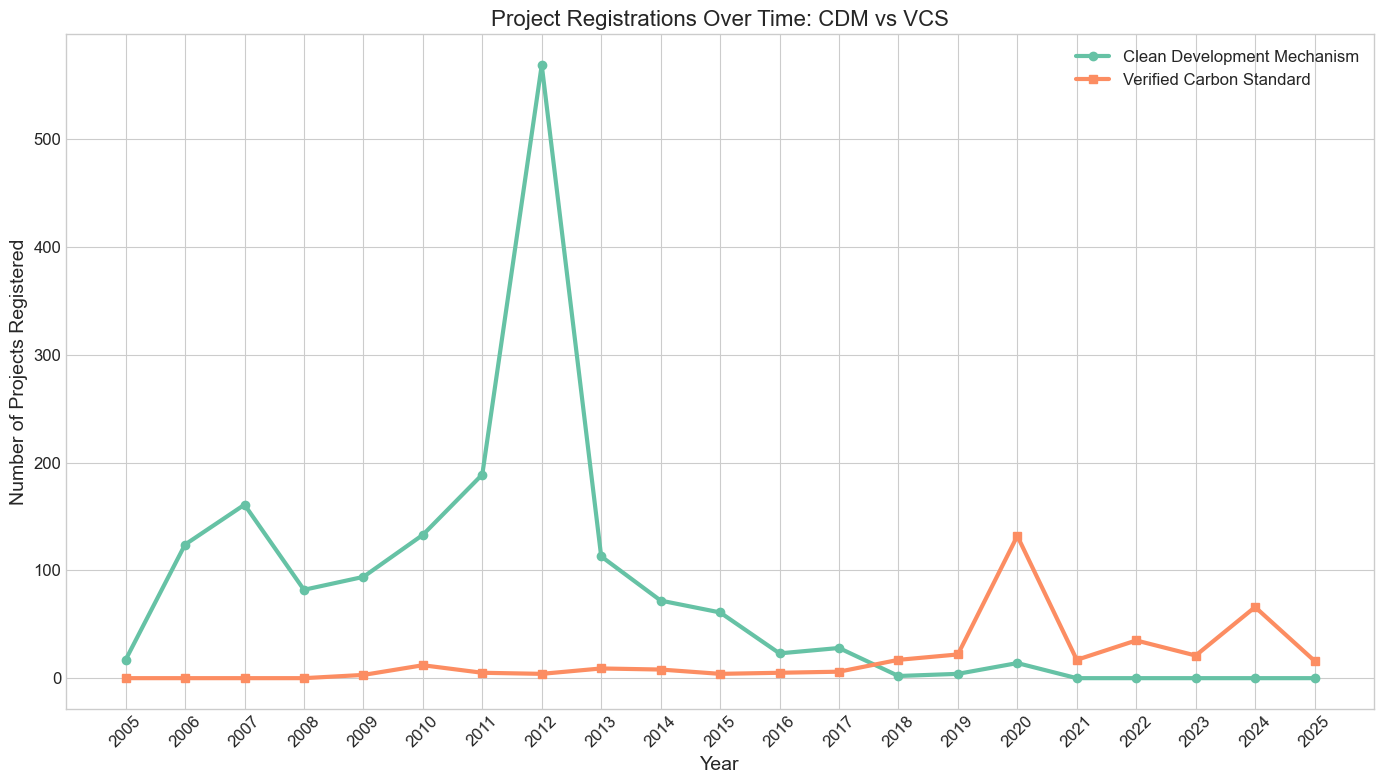

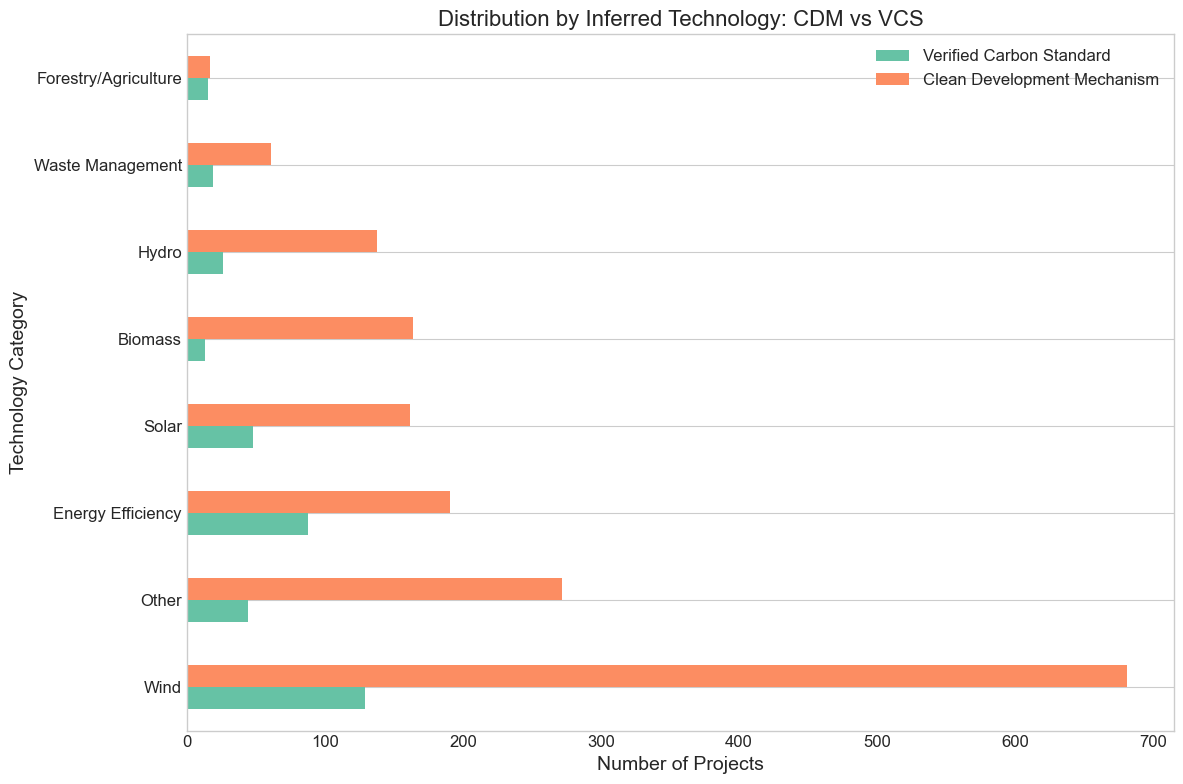

Technology distribution counts:
                      VCS  CDM
Technology                    
Wind                  129  681
Other                  44  272
Energy Efficiency      88  191
Solar                  48  162
Biomass                13  164
Hydro                  26  138
Waste Management       19   61
Forestry/Agriculture   15   17


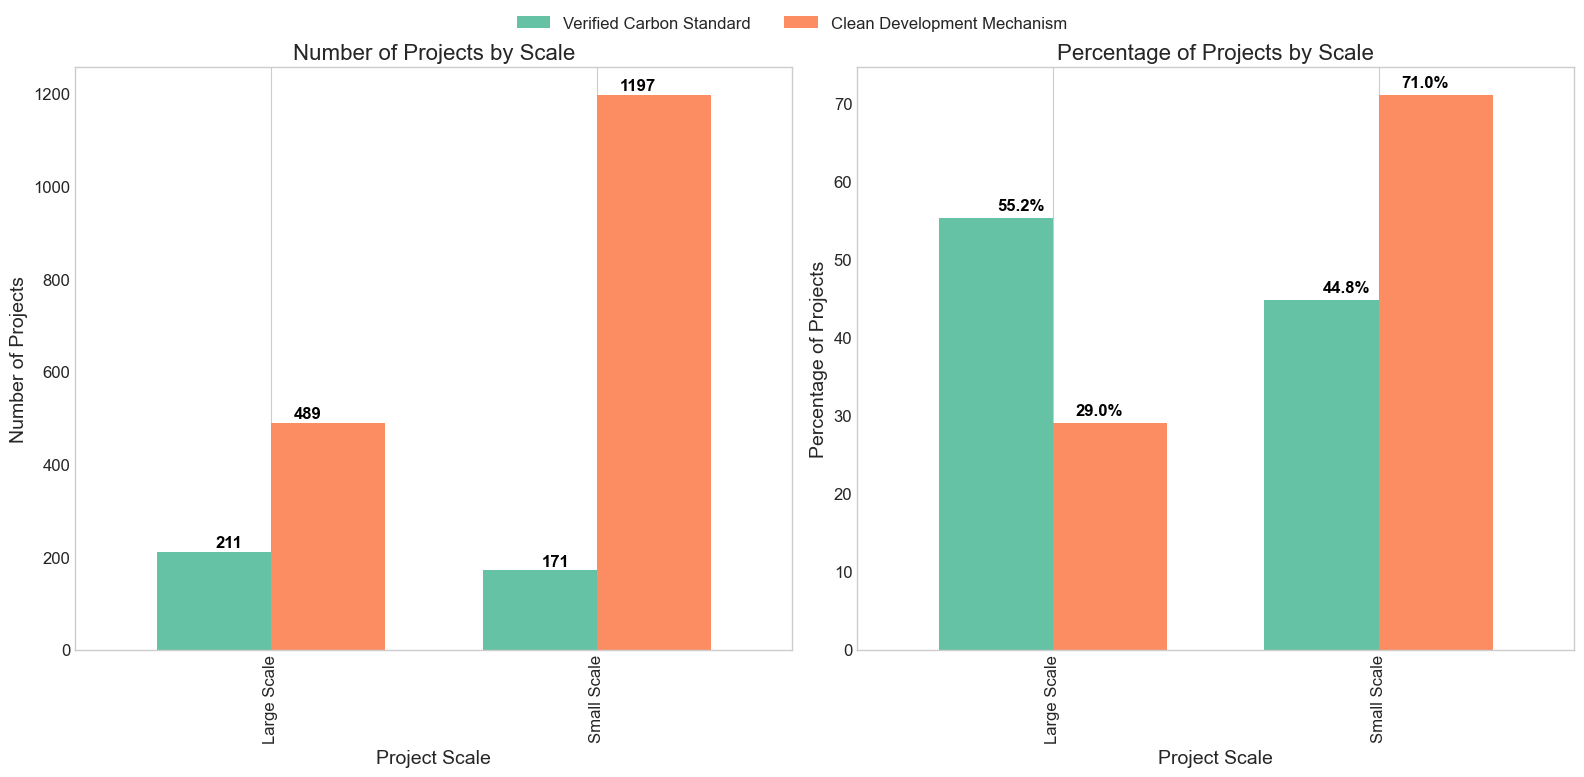

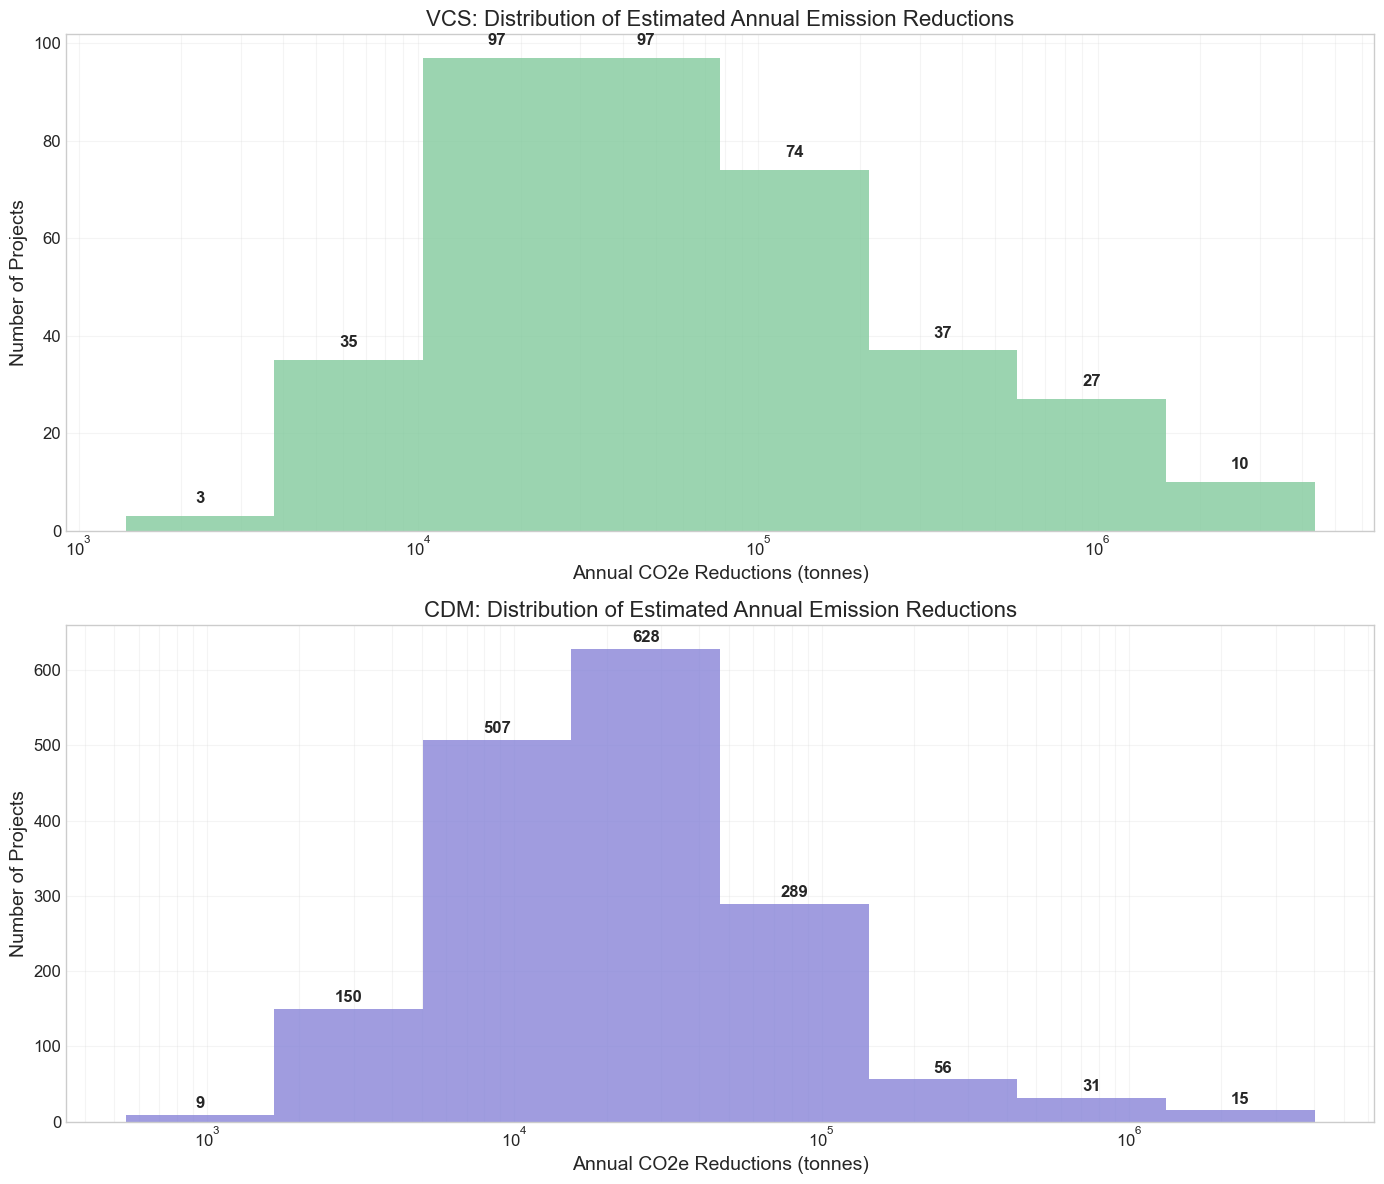

VCS Emission Reduction Statistics (tonnes CO2e):
  Min: 1,375
  Max: 4,354,646
  Median: 49,796
  Mean: 221,092

CDM Emission Reduction Statistics (tonnes CO2e):
  Min: 544
  Max: 4,017,202
  Median: 20,588
  Mean: 70,541


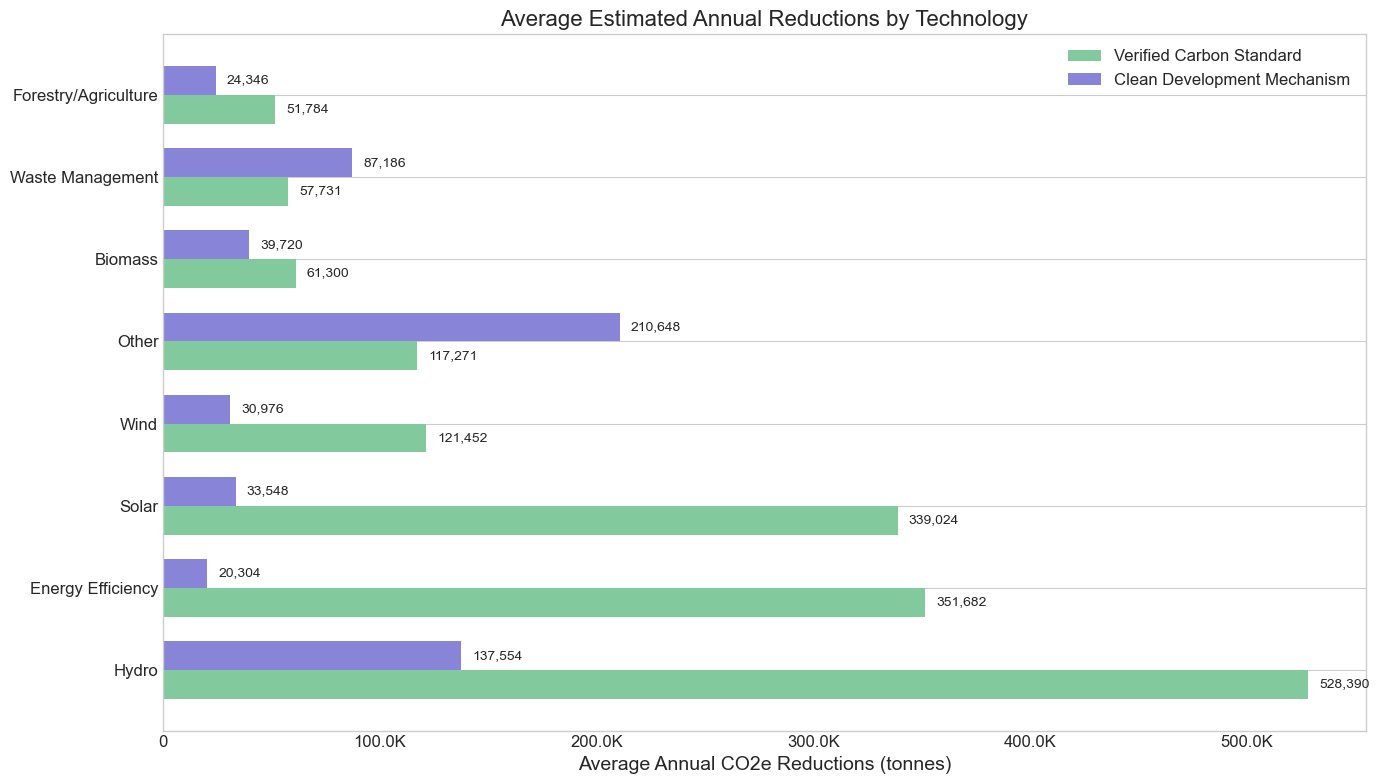

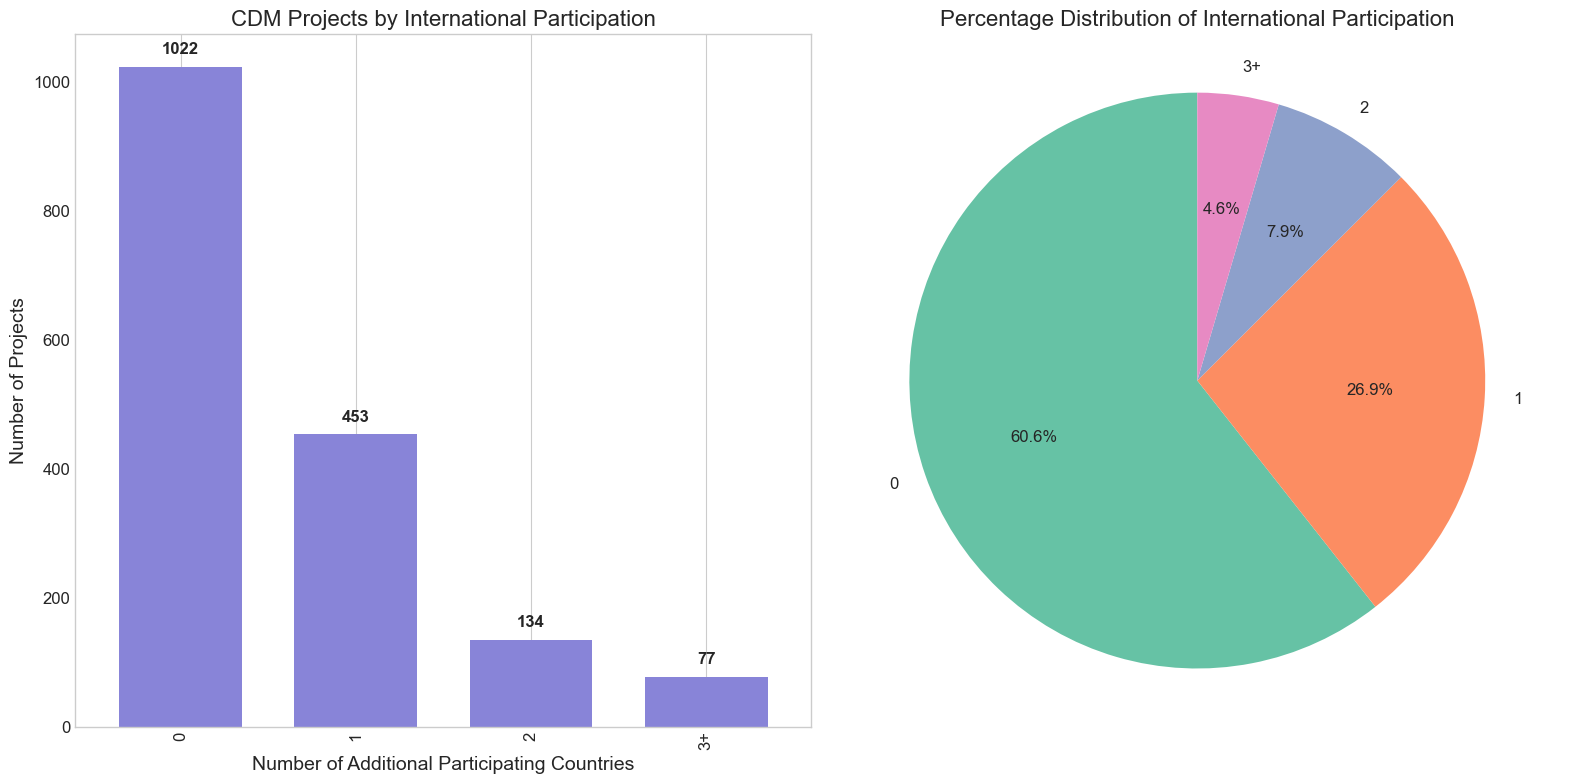

International participation distribution:
  0 additional countries: 1022 projects (60.6%)
  1 additional countries: 453 projects (26.9%)
  2 additional countries: 134 projects (7.9%)
  3+ additional countries: 77 projects (4.6%)


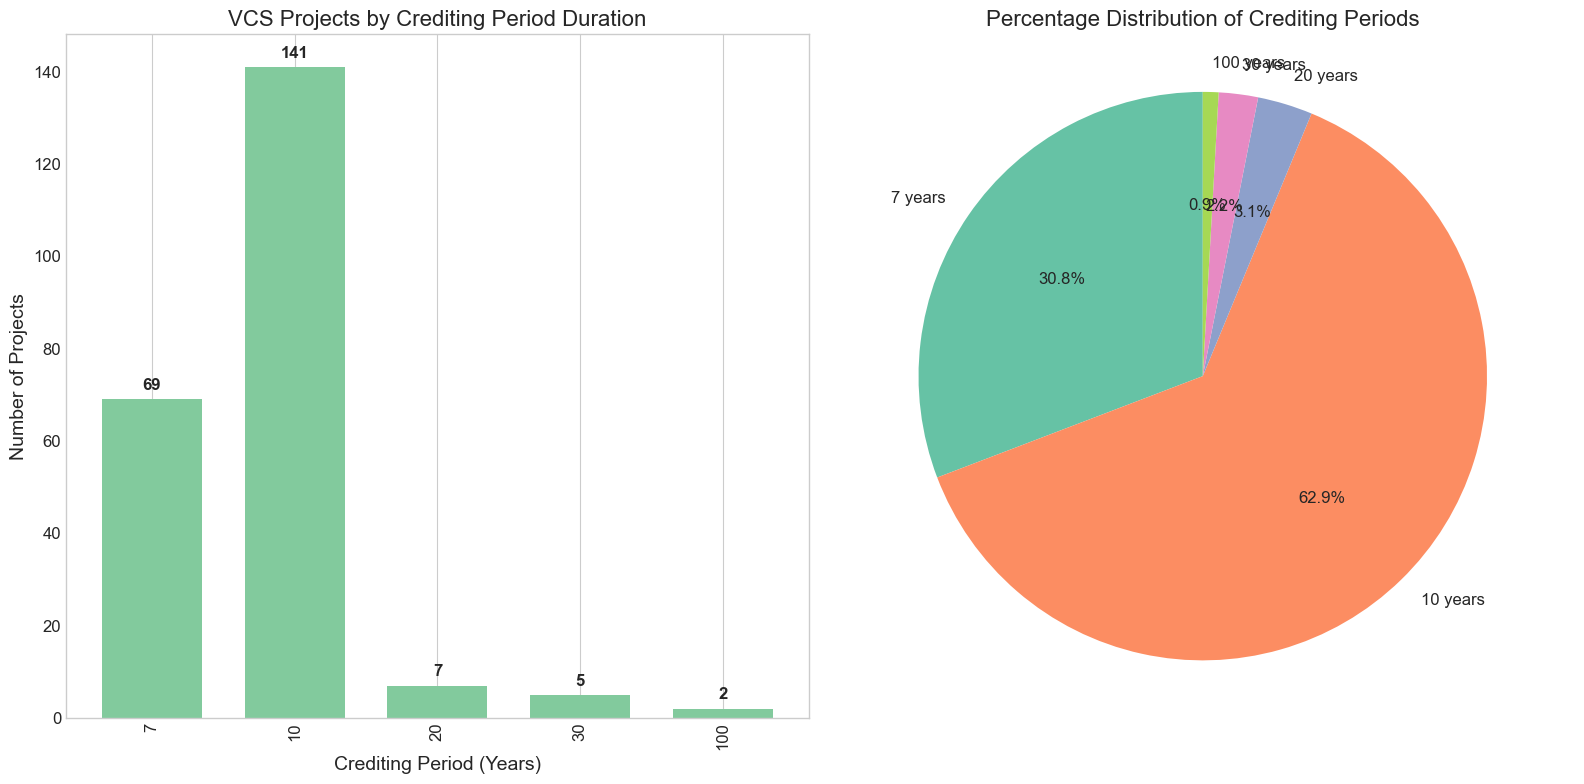

Crediting period distribution:
  7 years: 69 projects (30.8%)
  10 years: 141 projects (62.9%)
  20 years: 7 projects (3.1%)
  30 years: 5 projects (2.2%)
  100 years: 2 projects (0.9%)


In [ ]:
# Carbon Credits Analysis: Comparing CDM and VCS Projects

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# %% [markdown]
# ## Data Loading and Preprocessing
# 
# We'll start by loading and inspecting the VCS and CDM datasets.

# %%
# Load the datasets
vcs_df = pd.read_csv("registered_vcs.csv")
cdm_df = pd.read_csv("results_cdm.csv", encoding='cp1252')

# Display basic info
print("VCS Dataset Shape:", vcs_df.shape)
print("CDM Dataset Shape:", cdm_df.shape)

# Display column names
print("\nVCS Columns:", vcs_df.columns.tolist())
print("\nCDM Columns:", cdm_df.columns.tolist())

# Sample of each dataset
print("\nVCS Sample:")
display(vcs_df.head())

print("\nCDM Sample:")
display(cdm_df.head())

# %% [markdown]
# Let's clean and prepare the data for analysis. We'll need to:
# 1. Standardize date formats
# 2. Clean and convert emission reductions data
# 3. Add categorization for technologies based on titles and methodologies

# %%
# Function to parse dates from various formats
def parse_date(date_str):
    if pd.isna(date_str):
        return None
    
    # Try different date formats
    date_formats = [
        '%Y-%m-%d',  # 2025-04-23
        '%d-%m-%y',  # 23-04-25
        '%d/%m/%Y',  # 23/04/2025
        '%d/%m/%y',  # 23/04/25
        '%d-%b-%y',  # 23-Apr-25
        '%d-%b-%Y',  # 23-Apr-2025
        '%d %b %Y',  # 23 Apr 2025
    ]
    
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue
    
    return None

# Function to clean and convert emission reductions data
def parse_reductions(value):
    if pd.isna(value):
        return np.nan
    
    # If already a number, return it
    if isinstance(value, (int, float)):
        return value
    
    # Handle string formats
    try:
        # Remove commas and convert to float
        return float(str(value).replace(',', ''))
    except:
        return np.nan

# %%
# Clean VCS dates
vcs_df['Registration_Date'] = vcs_df['Project Registration Date'].apply(parse_date)
vcs_df['Crediting_Start'] = vcs_df['Crediting Period Start Date'].apply(parse_date)
vcs_df['Crediting_End'] = vcs_df['Crediting Period End Date'].apply(parse_date)

# Clean CDM dates
cdm_df['Registration_Date'] = cdm_df['Registered'].apply(parse_date)

# Clean emission reductions
vcs_df['Annual_Reductions'] = vcs_df['Estimated Annual Emission Reductions'].apply(parse_reductions)
cdm_df['Annual_Reductions'] = cdm_df['Reductions'].apply(parse_reductions)

# Calculate crediting period in years for VCS
vcs_df['Crediting_Period_Years'] = np.nan
mask = (~vcs_df['Crediting_Start'].isna()) & (~vcs_df['Crediting_End'].isna())
vcs_df.loc[mask, 'Crediting_Period_Years'] = (vcs_df.loc[mask, 'Crediting_End'] - 
                                             vcs_df.loc[mask, 'Crediting_Start']).dt.days / 365.25
vcs_df['Crediting_Period_Years'] = vcs_df['Crediting_Period_Years'].round().astype('Int64')

# %% [markdown]
# Now let's add technology categorization based on project names, types, and methodologies:

# %%
# Functions to categorize technology
def categorize_vcs_technology(row):
    project_type = str(row.get('Project Type', '')).lower()
    methodology = str(row.get('Methodology', '')).lower()
    name = str(row.get('Name', '')).lower()
    
    if 'wind' in project_type or 'wind' in methodology or 'wind' in name:
        return 'Wind'
    elif 'hydro' in project_type or 'hydro' in methodology or 'hydro' in name or ' shp' in name:
        return 'Hydro'
    elif 'solar' in project_type or 'solar' in methodology or 'solar' in name or ' pv' in name:
        return 'Solar'
    elif 'biomass' in project_type or 'biomass' in methodology or 'biomass' in name:
        return 'Biomass'
    elif 'energy efficiency' in project_type or 'energy demand' in project_type or 'efficiency' in methodology:
        return 'Energy Efficiency'
    elif 'waste' in project_type or 'landfill' in project_type or 'waste' in methodology or 'waste' in name:
        return 'Waste Management'
    elif ('forest' in project_type or 'afolu' in project_type or 'agriculture' in project_type or 
          'forest' in methodology or 'forest' in name or 'redd' in name):
        return 'Forestry/Agriculture'
    else:
        return 'Other'

def categorize_cdm_technology(row):
    title = str(row.get('Project title', '')).lower()
    methodology = str(row.get('Methodology', '')).lower()
    
    if 'wind' in title or 'wind' in methodology:
        return 'Wind'
    elif 'hydro' in title or 'hydro' in methodology or 'shp' in title:
        return 'Hydro'
    elif 'solar' in title or 'solar' in methodology or 'pv' in title:
        return 'Solar'
    elif 'biomass' in title or 'biomass' in methodology:
        return 'Biomass'
    elif 'energy efficiency' in title or 'efficiency' in methodology or 'ams-ii' in methodology:
        return 'Energy Efficiency'
    elif 'waste' in title or 'landfill' in title or 'waste' in methodology:
        return 'Waste Management'
    elif 'forest' in title or 'agriculture' in title or 'afforestation' in methodology:
        return 'Forestry/Agriculture'
    else:
        return 'Other'

# Function to determine if a project is small scale
def is_small_scale_vcs(row):
    methodology = str(row.get('Methodology', ''))
    return 'AMS' in methodology or 'small' in methodology.lower()

def is_small_scale_cdm(row):
    methodology = str(row.get('Methodology', ''))
    return 'AMS' in methodology

# Apply technology categorization
vcs_df['Technology'] = vcs_df.apply(categorize_vcs_technology, axis=1)
cdm_df['Technology'] = cdm_df.apply(categorize_cdm_technology, axis=1)

# Apply scale categorization
vcs_df['Scale'] = vcs_df.apply(lambda row: 'Small Scale' if is_small_scale_vcs(row) else 'Large Scale', axis=1)
cdm_df['Scale'] = cdm_df.apply(lambda row: 'Small Scale' if is_small_scale_cdm(row) else 'Large Scale', axis=1)

# %% [markdown]
# Now let's count the number of international participants in CDM projects:

# %%
# Function to count number of other participating countries in CDM projects
def count_other_parties(other_parties):
    if pd.isna(other_parties) or other_parties == '':
        return 0
    
    # Split by common delimiters and count non-empty entries
    participants = re.split(r'[\/,;]', str(other_parties))
    return len([p for p in participants if p.strip() != ''])

# Add international participation count
cdm_df['International_Participants'] = cdm_df['Other Parties'].apply(count_other_parties)
cdm_df['International_Participation_Category'] = cdm_df['International_Participants'].apply(
    lambda x: '0' if x == 0 else '1' if x == 1 else '2' if x == 2 else '3+'
)

# %% [markdown]
# ## Plot 1: Project Registrations Over Time
# 
# Let's create a line chart showing the number of CDM and VCS projects registered per year.

# %%
# Count projects by registration year
vcs_reg_by_year = vcs_df.groupby(vcs_df['Registration_Date'].dt.year).size()
cdm_reg_by_year = cdm_df.groupby(cdm_df['Registration_Date'].dt.year).size()

# Create a time series data frame with all years
all_years = sorted(list(set(vcs_reg_by_year.index) | set(cdm_reg_by_year.index)))
time_series_df = pd.DataFrame(index=all_years)
time_series_df['VCS'] = vcs_reg_by_year
time_series_df['CDM'] = cdm_reg_by_year
time_series_df.fillna(0, inplace=True)
time_series_df = time_series_df.astype(int)

# Create the plot
plt.figure(figsize=(14, 8))
plt.plot(time_series_df.index, time_series_df['CDM'], marker='o', linewidth=3, label='Clean Development Mechanism')
plt.plot(time_series_df.index, time_series_df['VCS'], marker='s', linewidth=3, label='Verified Carbon Standard')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Projects Registered', fontsize=14)
plt.title('Project Registrations Over Time: CDM vs VCS', fontsize=16)
plt.xticks(all_years, rotation=45)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# %% [markdown]
# **Findings:**
# 
# The registration patterns for CDM and VCS show distinct trends over time:
# 
# - **CDM Registrations:** CDM was the dominant standard in early years, with registrations rising steadily from 2005 through 2012, when it reached its peak of 569 projects. After 2012, there was a dramatic decline, with very few projects registered after 2017.
# 
# - **VCS Registrations:** VCS shows a different pattern, with modest growth from 2009-2019, followed by a significant spike in 2020 with 132 projects. VCS became the more active standard after 2018.
# 
# - **Transition in Carbon Markets:** The chart clearly shows a transition in carbon markets from CDM to VCS as the preferred certification standard. This likely reflects policy changes, particularly the uncertainty about CDM's future after the first Kyoto commitment period ended in 2012.
# 
# - **Recent Trends:** VCS has maintained strong activity through 2024, while CDM activity has remained minimal, suggesting a long-term shift in market preferences.

# %% [markdown]
# ## Plot 2: Distribution by Inferred Technology
# 
# Let's create a bar chart comparing the count of projects across major technology categories for CDM and VCS.

# %%
# Count projects by technology category
vcs_tech_counts = vcs_df['Technology'].value_counts()
cdm_tech_counts = cdm_df['Technology'].value_counts()

# Combine into a dataframe
tech_df = pd.DataFrame({
    'VCS': vcs_tech_counts,
    'CDM': cdm_tech_counts
})
tech_df.fillna(0, inplace=True)
tech_df = tech_df.astype(int)

# Sort by total count
tech_df['Total'] = tech_df['VCS'] + tech_df['CDM']
tech_df = tech_df.sort_values('Total', ascending=False)
tech_df = tech_df.drop('Total', axis=1)

# Create the plot
tech_df.plot(kind='barh', figsize=(12, 8))
plt.xlabel('Number of Projects', fontsize=14)
plt.ylabel('Technology Category', fontsize=14)
plt.title('Distribution by Inferred Technology: CDM vs VCS', fontsize=16)
plt.legend(labels=['Verified Carbon Standard', 'Clean Development Mechanism'])
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Print the actual counts
print("Technology distribution counts:")
print(tech_df)

# %% [markdown]
# **Findings:**
# 
# The distribution of projects across technology categories reveals significant differences between CDM and VCS:
# 
# - **Wind Energy:** Wind is the most common technology in CDM projects, accounting for a substantial portion of all CDM activities. VCS also has significant wind projects, though proportionally fewer than CDM.
# 
# - **Energy Efficiency:** Both standards have substantial energy efficiency projects, representing a key area for emissions reduction.
# 
# - **Diverse Technologies:** Both standards include a range of renewable energy technologies (solar, hydro, biomass), though with different proportions.
# 
# - **Other Category:** VCS has a relatively larger "Other" category, suggesting either more diverse project types or less standardized categorization in the data.
# 
# - **Forestry/Agriculture:** Both standards have a smaller proportion of forestry and agricultural projects, though these often have larger per-project impact on emissions.
# 
# The differences in technology distribution likely reflect the different regulatory environments, methodological approaches, and target markets of each standard.

# %% [markdown]
# ## Plot 3: Distribution by Inferred Scale
# 
# Let's create bar charts showing the number and proportion of Small Scale vs. Large Scale projects for CDM and VCS.

# %%
# Count projects by scale
vcs_scale_counts = vcs_df['Scale'].value_counts()
cdm_scale_counts = cdm_df['Scale'].value_counts()

# Combine into a dataframe
scale_df = pd.DataFrame({
    'VCS': vcs_scale_counts,
    'CDM': cdm_scale_counts
})
scale_df.fillna(0, inplace=True)
scale_df = scale_df.astype(int)

# Calculate percentages
vcs_total = vcs_scale_counts.sum()
cdm_total = cdm_scale_counts.sum()
scale_percent_df = pd.DataFrame({
    'VCS': vcs_scale_counts / vcs_total * 100,
    'CDM': cdm_scale_counts / cdm_total * 100
})

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Count plot
scale_df.plot(kind='bar', ax=ax1, width=0.7)
ax1.set_xlabel('Project Scale', fontsize=14)
ax1.set_ylabel('Number of Projects', fontsize=14)
ax1.set_title('Number of Projects by Scale', fontsize=16)
ax1.grid(axis='y')

# Add count labels
for i, v in enumerate(scale_df['VCS']):
    ax1.text(i-0.17, v+10, str(v), color='black', fontweight='bold')
for i, v in enumerate(scale_df['CDM']):
    ax1.text(i+0.07, v+10, str(v), color='black', fontweight='bold')

# Percentage plot
scale_percent_df.plot(kind='bar', ax=ax2, width=0.7)
ax2.set_xlabel('Project Scale', fontsize=14)
ax2.set_ylabel('Percentage of Projects', fontsize=14)
ax2.set_title('Percentage of Projects by Scale', fontsize=16)
ax2.grid(axis='y')

# Add percentage labels
for i, v in enumerate(scale_percent_df['VCS']):
    ax2.text(i-0.17, v+1, f"{v:.1f}%", color='black', fontweight='bold')
for i, v in enumerate(scale_percent_df['CDM']):
    ax2.text(i+0.07, v+1, f"{v:.1f}%", color='black', fontweight='bold')

# Legend and layout
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, ['Verified Carbon Standard', 'Clean Development Mechanism'], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=12)
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# %% [markdown]
# **Findings:**
# 
# The analysis of project scale reveals significant differences between CDM and VCS:
# 
# - **CDM Small-Scale Dominance:** CDM shows a strong preference for small-scale projects, with approximately 71% of all projects falling into this category. This reflects CDM's design which includes simplified procedures for small-scale projects to encourage wider participation.
# 
# - **VCS Large-Scale Focus:** VCS has a more balanced distribution, with large-scale projects slightly outnumbering small-scale ones. Approximately 55% of VCS projects are large-scale, compared to only 29% in CDM.
# 
# - **Absolute Numbers:** In absolute terms, the number of small-scale CDM projects (1,197) far exceeds the total number of VCS projects (382), highlighting CDM's broader historical reach.
# 
# - **Market Implications:** The scale difference suggests that the standards may serve different market segments, with CDM facilitating more numerous, smaller interventions while VCS accommodates larger, potentially more complex projects.
# 
# - **Regulatory Influence:** The difference in scale distribution may reflect the different regulatory frameworks and incentive structures of each standard, as well as the types of project developers they attract.

# %% [markdown]
# ## Plot 4: Distribution of Estimated Annual Emission Reductions
# 
# Let's create histograms showing the frequency distribution of estimated annual CO2e reductions for CDM and VCS projects.

# %%
# Filter out missing values
vcs_reductions = vcs_df['Annual_Reductions'].dropna()
cdm_reductions = cdm_df['Annual_Reductions'].dropna()

# Create log-scale bins for better visualization
def create_log_bins(data, num_bins=8):
    non_zero_data = data[data > 0]
    log_min = np.log10(non_zero_data.min())
    log_max = np.log10(non_zero_data.max())
    return np.logspace(log_min, log_max, num_bins + 1)

vcs_bins = create_log_bins(vcs_reductions)
cdm_bins = create_log_bins(cdm_reductions)

# Format function for bin labels
def format_number(num):
    if num >= 1000000:
        return f"{num/1000000:.1f}M"
    elif num >= 1000:
        return f"{num/1000:.1f}K"
    else:
        return f"{int(num)}"

# Create the subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# VCS histogram
counts, bins, patches = ax1.hist(vcs_reductions, bins=vcs_bins, alpha=0.8, color='#82ca9d')
ax1.set_xscale('log')
ax1.set_title('VCS: Distribution of Estimated Annual Emission Reductions', fontsize=16)
ax1.set_xlabel('Annual CO2e Reductions (tonnes)', fontsize=14)
ax1.set_ylabel('Number of Projects', fontsize=14)
ax1.grid(True, which="both", ls="-", alpha=0.2)

# Add count labels
for i, (count, bin_edge) in enumerate(zip(counts, bins[:-1])):
    if count > 0:
        ax1.text(np.sqrt(bin_edge * bins[i+1]), count + 2, int(count), 
                 ha='center', va='bottom', fontweight='bold')

# CDM histogram
counts, bins, patches = ax2.hist(cdm_reductions, bins=cdm_bins, alpha=0.8, color='#8884d8')
ax2.set_xscale('log')
ax2.set_title('CDM: Distribution of Estimated Annual Emission Reductions', fontsize=16)
ax2.set_xlabel('Annual CO2e Reductions (tonnes)', fontsize=14)
ax2.set_ylabel('Number of Projects', fontsize=14)
ax2.grid(True, which="both", ls="-", alpha=0.2)

# Add count labels
for i, (count, bin_edge) in enumerate(zip(counts, bins[:-1])):
    if count > 0:
        ax2.text(np.sqrt(bin_edge * bins[i+1]), count + 5, int(count), 
                 ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate summary statistics
vcs_stats = {
    'Min': vcs_reductions.min(),
    'Max': vcs_reductions.max(),
    'Median': vcs_reductions.median(),
    'Mean': vcs_reductions.mean()
}

cdm_stats = {
    'Min': cdm_reductions.min(),
    'Max': cdm_reductions.max(),
    'Median': cdm_reductions.median(),
    'Mean': cdm_reductions.mean()
}

print("VCS Emission Reduction Statistics (tonnes CO2e):")
for stat, value in vcs_stats.items():
    print(f"  {stat}: {value:,.0f}")

print("\nCDM Emission Reduction Statistics (tonnes CO2e):")
for stat, value in cdm_stats.items():
    print(f"  {stat}: {value:,.0f}")

# %% [markdown]
# **Findings:**
# 
# The distribution of estimated annual emission reductions reveals the scale and impact of projects under both standards:
# 
# - **Wide Range of Project Sizes:** Both CDM and VCS projects span several orders of magnitude in emission reduction potential, from around 1,000 tonnes to over 4 million tonnes of CO2e per year.
# 
# - **Modal Distribution:** The most common project size for both standards falls in the 10,000-100,000 tonnes CO2e range, representing a "sweet spot" for carbon project viability.
# 
# - **VCS Project Size:** VCS projects show a median annual reduction of approximately 37,000 tonnes CO2e, with a wide distribution and several very large projects.
# 
# - **CDM Project Size:** CDM projects have a slightly lower median annual reduction of around 29,000 tonnes CO2e, with a concentration in the mid-range categories.
# 
# - **Large Projects Influence:** Both standards include a small number of very large projects (>1M tonnes CO2e), which have an outsized impact on the total emission reductions claimed under each standard.
# 
# - **Log Distribution:** The logarithmic distribution highlights how project sizes span multiple orders of magnitude, which is characteristic of carbon markets where different types of interventions have vastly different scales of impact.

# %% [markdown]
# ## Plot 5: Average Estimated Annual Reductions by Technology
# 
# Let's create a bar chart comparing the average estimated annual reductions per project across different technology categories for CDM and VCS.

# %%
# Calculate average reductions by technology for VCS
vcs_avg_by_tech = vcs_df.groupby('Technology')['Annual_Reductions'].mean().reset_index()
vcs_avg_by_tech.columns = ['Technology', 'VCS']

# Calculate average reductions by technology for CDM
cdm_avg_by_tech = cdm_df.groupby('Technology')['Annual_Reductions'].mean().reset_index()
cdm_avg_by_tech.columns = ['Technology', 'CDM']

# Merge the two dataframes
avg_by_tech = pd.merge(vcs_avg_by_tech, cdm_avg_by_tech, on='Technology', how='outer')
avg_by_tech.fillna(0, inplace=True)

# Sort by VCS reductions (descending)
avg_by_tech = avg_by_tech.sort_values('VCS', ascending=False)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Set position of bars on x-axis
x = np.arange(len(avg_by_tech))
width = 0.35

# Create bars
vcs_bars = ax.barh(x - width/2, avg_by_tech['VCS'], width, label='Verified Carbon Standard', color='#82ca9d')
cdm_bars = ax.barh(x + width/2, avg_by_tech['CDM'], width, label='Clean Development Mechanism', color='#8884d8')

# Add labels, title and legend
ax.set_xlabel('Average Annual CO2e Reductions (tonnes)', fontsize=14)
ax.set_yticks(x)
ax.set_yticklabels(avg_by_tech['Technology'])
ax.set_title('Average Estimated Annual Reductions by Technology', fontsize=16)
ax.legend()

# Format x-axis labels for better readability
def format_thousand(x, pos):
    if x >= 1000000:
        return f'{x/1000000:.1f}M'
    elif x >= 1000:
        return f'{x/1000:.1f}K'
    else:
        return f'{int(x)}'

from matplotlib.ticker import FuncFormatter
ax.xaxis.set_major_formatter(FuncFormatter(format_thousand))

# Add value labels to bars
for i, v in enumerate(avg_by_tech['VCS']):
    if v > 0:
        ax.text(v + 5000, i - width/2, f'{v:,.0f}', va='center', fontsize=10)
        
for i, v in enumerate(avg_by_tech['CDM']):
    if v > 0:
        ax.text(v + 5000, i + width/2, f'{v:,.0f}', va='center', fontsize=10)

plt.grid(axis='x')
plt.tight_layout()
plt.show()

# %% [markdown]
# **Findings:**
# 
# The average estimated annual reductions by technology category reveal important patterns in project impact:
# 
# - **VCS Energy Efficiency:** Energy Efficiency projects under VCS have the highest average annual emissions reductions at around 345,000 tonnes CO2e per project. This suggests that VCS attracts larger, more impactful energy efficiency initiatives.
# 
# - **Industrial Gas Projects:** The "Other" category, which includes industrial gas projects (such as HFC-23 destruction), shows high average reductions in both standards. These projects are known for their high GHG-reduction potential relative to implementation costs.
# 
# - **Technology-Specific Patterns:** Different technologies show distinct patterns between the two standards:
#   - Waste Management projects have similar average reductions in both standards
#   - Hydro projects are significantly larger on average under CDM
#   - Wind projects show comparable average reductions across both standards
# 
# - **Scale Differences:** VCS projects generally have larger average emissions reductions compared to CDM projects in most categories, suggesting a focus on larger-scale interventions.
# 
# - **Methodological Differences:** The variation in average reductions may reflect different methodological approaches between the standards, including different baseline calculation methods, eligibility criteria, and validation requirements.

# %% [markdown]
# ## Plot 6: CDM Project International Participation
# 
# Let's create bar and pie charts showing the distribution of the number of additional participating countries involved in CDM projects.

# %%
# Count projects by international participation category
int_participation = cdm_df['International_Participation_Category'].value_counts().sort_index()

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart
int_participation.plot(kind='bar', ax=ax1, color='#8884d8', width=0.7)
ax1.set_xlabel('Number of Additional Participating Countries', fontsize=14)
ax1.set_ylabel('Number of Projects', fontsize=14)
ax1.set_title('CDM Projects by International Participation', fontsize=16)
ax1.grid(axis='y')

# Add count labels
for i, v in enumerate(int_participation):
    ax1.text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pie chart
int_participation_pct = int_participation / int_participation.sum() * 100
ax2.pie(int_participation_pct, labels=int_participation.index, 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
ax2.set_title('Percentage Distribution of International Participation', fontsize=16)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Print the actual counts and percentages
print("International participation distribution:")
for category, count in int_participation.items():
    percent = count / int_participation.sum() * 100
    print(f"  {category} additional countries: {count} projects ({percent:.1f}%)")

# %% [markdown]
# **Findings:**
# 
# The analysis of international participation in CDM projects reveals important patterns in cross-border climate finance:
# 
# - **Predominantly National Projects:** The majority of CDM projects (61%) have no additional participating countries beyond the host nation. These projects likely rely on domestic funding or unilateral CDM approaches.
# 
# - **Bilateral Participation:** Approximately 27% of CDM projects involve one additional participating country, representing the traditional bilateral CDM structure where a developed nation invests in emission reductions in a developing country.
# 
# - **Multi-Country Participation:** Projects with two or more additional participating countries (12% combined) represent more complex international collaborations, potentially involving multiple investors or multinational partnerships.
# 
# - **Market Implications:** The distribution suggests that while the CDM was designed to facilitate international cooperation in emission reductions, in practice, many projects operate with limited international participation. This may reflect:
#   - The evolution of the CDM market over time
#   - The growing capacity of host countries to develop their own projects
#   - The diverse funding models that have emerged in the carbon market
# 
# - **Investment Patterns:** Projects with multiple international participants may represent larger or more complex initiatives requiring more diverse funding sources, or they may reflect strategic partnerships among countries with common climate objectives.

# %% [markdown]
# ## Plot 7: Planned Crediting Period Duration (VCS)
# 
# Let's create a histogram showing the distribution of the planned project lifetime (in years) for VCS projects.

# %%
# Filter out missing values
crediting_periods = vcs_df['Crediting_Period_Years'].dropna()

# Count frequency of each crediting period length
period_counts = crediting_periods.value_counts().sort_index()

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart
period_counts.plot(kind='bar', ax=ax1, color='#82ca9d', width=0.7)
ax1.set_xlabel('Crediting Period (Years)', fontsize=14)
ax1.set_ylabel('Number of Projects', fontsize=14)
ax1.set_title('VCS Projects by Crediting Period Duration', fontsize=16)
ax1.grid(axis='y')

# Add count labels
for i, v in enumerate(period_counts):
    ax1.text(i, v + 2, str(v), ha='center', fontweight='bold')

# Pie chart
period_counts_pct = period_counts / period_counts.sum() * 100
colors = sns.color_palette("Set2", len(period_counts))

ax2.pie(period_counts_pct, labels=[f"{idx} years" for idx in period_counts.index], 
        autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('Percentage Distribution of Crediting Periods', fontsize=16)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

# Print the actual counts and percentages
print("Crediting period distribution:")
for period, count in period_counts.items():
    percent = count / period_counts.sum() * 100
    print(f"  {period} years: {count} projects ({percent:.1f}%)")

# %% [markdown]
# **Findings:**
# 
# The analysis of planned crediting periods for VCS projects reveals important patterns in project timeframes:
# 
# - **Standard Duration Preference:** The majority of VCS projects have a crediting period of 7-10 years, with 10 years being the most common duration (accounting for approximately 63% of projects).
# 
# - **Short vs. Long-Term Projects:** The concentration of projects in the 7-10 year range reflects a balance between ensuring project viability through adequate crediting periods while maintaining reasonable verification timelines.
# 
# - **Longer Crediting Periods:** A smaller number of projects have longer crediting periods (20-30 years), which typically represent forestry, agriculture, or land-use projects with longer-term carbon sequestration benefits.
# 
# - **Very Long Periods:** The few projects with extremely long crediting periods (30+ years) suggest special project types with unique characteristics, such as afforestation or reforestation with long-term carbon storage.
# 
# - **Policy Implications:** The distribution of crediting periods reflects both the technical aspects of different project types and the policy design of the VCS standard, which allows flexibility in crediting periods to accommodate diverse project needs.
# 
# - **Risk Considerations:** Shorter crediting periods may offer less uncertainty for investors, while longer periods provide more stable revenue streams for project developers but come with greater long-term performance risks.

# %% [markdown]
# ## Summary of Key Findings
# 
# Our comparative analysis of the Clean Development Mechanism (CDM) and Verified Carbon Standard (VCS) reveals several important patterns and contrasts between these two major carbon crediting standards:
# 
# ### Temporal Patterns
# - CDM dominated the carbon markets from 2005-2012, peaking in 2012, while VCS has become the more active standard since 2018.
# - The transition from CDM to VCS reflects changing market dynamics and policy environments in carbon markets.
# 
# ### Project Characteristics
# - **Technology Mix:** Both standards feature a range of technologies, but with different distributions. Wind projects are more dominant in CDM, while VCS shows a more diverse technology portfolio.
# - **Scale Distribution:** CDM has a higher proportion of small-scale projects (71%) compared to VCS (45%), suggesting different target markets and regulatory approaches.
# - **Emission Reductions:** Projects under both standards span several orders of magnitude in emission reduction potential, typically ranging from 10,000 to 100,000 tonnes CO2e per year.
# - **Crediting Periods:** VCS projects predominantly use 10-year crediting periods, with longer periods reserved for forestry and land-use projects with longer carbon sequestration timelines.
# 
# ### Market Structure
# - **International Participation:** The majority of CDM projects (61%) operate without additional international participants, challenging the notion that CDM primarily facilitates cross-border climate finance.
# - **Impact per Project:** VCS projects generally have larger average emissions reductions compared to CDM projects in most technology categories, suggesting a focus on larger-scale interventions.
# 
# ### Implications
# - The shift from CDM to VCS represents an evolution in carbon markets from compliance-driven to more voluntary approaches.
# - Different standards serve different market niches, with variations in project scale, technology focus, and international participation.
# - The diversity in project characteristics within each standard highlights the heterogeneity of carbon reduction opportunities and approaches.
# 
# These findings contribute to our understanding of how carbon market mechanisms have evolved over time and how different standards facilitate different types of emission reduction projects.